In [1]:
import torch
import numpy as np
from PIL import Image
from datasets import load_dataset 
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer, ViTFeatureExtractor
import os
import time
import datasets
import aiohttp
from datasets import load_dataset, Features, Image as ImageFeature
import torch
import random
   

2025-10-15 14:55:43.429192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sys
print(sys.path)

['/opt/anaconda3/envs/cnnenv/lib/python39.zip', '/opt/anaconda3/envs/cnnenv/lib/python3.9', '/opt/anaconda3/envs/cnnenv/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/cnnenv/lib/python3.9/site-packages', '/opt/anaconda3/envs/cnnenv/lib/python3.9/site-packages/setuptools/_vendor']


In [3]:



# Enable an emergency retry mechanism
os.environ["HF_HUB_ENABLE_EMERGENCY_RETRY"] = "True"
# Set a longer wait time between retries
os.environ["HF_HUB_EMERGENCY_RETRY_WAIT_TIME"] = "15" # Wait for 15 seconds


retry_attempts = 3

for attempt in range(retry_attempts):
    try:
        dataset_train = load_dataset("LaurenGurgiolo/Micro_Facial_Expressions", split = 'train')
        dataset_test = load_dataset("LaurenGurgiolo/Micro_Facial_Expressions", split = 'test')
        print("Dataset loaded successfully.")
       
        break
    except TimeoutError:
        print(f"Attempt {attempt + 1} failed, retrying...")
        if attempt < retry_attempts - 1:
            time.sleep(15)
        else:
            raise
dataset_train = dataset_train.shuffle(seed=42)
dataset_test = dataset_test.shuffle(seed=42)
print(dataset_train.shape) 
print(dataset_test.shape) 
id_to_emotion = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    4: "Happy",
    5: "Neutral",
    6: 'Sad',
    8: "Surprise",
}
dataset_train

Resolving data files:   0%|          | 0/36334 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1860 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/36334 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1860 [00:00<?, ?it/s]

Dataset loaded successfully.
(36334, 2)
(1860, 2)


Dataset({
    features: ['image', 'label'],
    num_rows: 36334
})

In [4]:
print(dataset_train.column_names)

['image', 'label']


In [5]:
# 2. Configure the pretrained ViT model
# Load the pre-trained processor and model
model_name = "mo-thecreator/vit-Facial-Expression-Recognition"
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = ViTImageProcessor.from_pretrained(model_name)



# Check the number of labels in the dataset
# Adjust the model's classifier head for the new dataset
num_labels = len(dataset_train.features['label'].names)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
)

print(dataset_train.features['label'].names)
print(dataset_test.features['label'].names)
print(dataset_train)
dataset_train.features['label']
dataset_test.features['label']


Some weights of ViTForImageClassification were not initialized from the model checkpoint at mo-thecreator/vit-Facial-Expression-Recognition and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['anger', 'disgust', 'fear', 'happiness', 'happy', 'neutral', 'sad', 'sadness', 'surprise']
['anger', 'disgust', 'fear', 'happiness', 'happy', 'neutral', 'sad', 'sadness', 'surprise']
Dataset({
    features: ['image', 'label'],
    num_rows: 36334
})


ClassLabel(names=['anger', 'disgust', 'fear', 'happiness', 'happy', 'neutral', 'sad', 'sadness', 'surprise'])

In [6]:
# Define a function to update the 'label'
def update_labels(example):
    
    if example['label'] == 7:
        example['label'] = 6
    if example['label'] == 3:
        example['label'] = 4
    return example

# Apply the function to the training dataset
dataset_train = dataset_train.map(update_labels) 
dataset_test = dataset_test.map(update_labels)



dataset_train

Dataset({
    features: ['image', 'label'],
    num_rows: 36334
})

In [7]:

# 1. Load the dataset
# Load a smaller split, like "validation", for faster testing


feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# 3. Create a preprocessing function
# This function prepares a single example from the dataset for the model.
# It correctly applies the processor to the 'image' and 'label' columns.
# 3. Create a preprocessing function.
#    The `preprocess_example` function now accepts a dictionary (`example`) as input.
def preprocess_example(example):
    # This correctly extracts the image and label from the example dictionary.
    image = example['image']
    label = example['label']
    image = image.convert("RGB") 
    # Process the image with the feature extractor.
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    return {k: v.squeeze() for k, v in inputs.items()}

# 4. Apply the preprocessing function to the entire dataset using .map().
#    The `map` method passes each example (a dictionary) to the function.
processed_train = dataset_train.map(preprocess_example, batched=False)
processed_test = dataset_test.map(preprocess_example, batched=False)



# 5. Inspect a single processed example
# The output now contains the processed image ('pixel_values') and the label.
# The 'ValueError' is avoided because the unpacking is handled internally
# by the dataset's iteration, which expects a single dictionary from the transform function.

print(processed_train)
processed_test

/opt/anaconda3/envs/cnnenv/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 36334
})


Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 1860
})

In [8]:
# 4. Set up the Trainer and training arguments
# Define the training parameters
from torch.utils.data import DataLoader

# Assuming your custom dataset returns image tensors of shape (3, height, width)

training_args = TrainingArguments(
    output_dir="./vit-micro-facial-expressions",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_dir='./logs',
    learning_rate=3e-5,
    push_to_hub=False, 
    # Set to True to push the model to Hugging Face Hub
)


In [9]:
# Define a function to compute evaluation metrics
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels, *_ = eval_pred  # Unpack only the first two elements and ignore the rest
    predictions = np.argmax(predictions, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [10]:
# Initialize the Trainer


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= processed_train,
    eval_dataset=processed_test, # Assuming a 'test' split for evaluation
    compute_metrics=compute_metrics,
    
)




In [11]:
# 5. Train the model
print("Starting training...")
trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.523100,0.467784,0.851613
2,0.259200,0.453949,0.872581
3,0.143300,0.528607,0.869355
4,0.060700,0.571582,0.875269


TrainOutput(global_step=9084, training_loss=0.28006077222181597, metrics={'train_runtime': 13257.0568, 'train_samples_per_second': 10.963, 'train_steps_per_second': 0.685, 'total_flos': 1.1263082390410346e+19, 'train_loss': 0.28006077222181597, 'epoch': 4.0})

In [12]:
# 6. Evaluate the model on the test set
print("Evaluating the trained model...")
eval_results = trainer.evaluate()
print(eval_results)

Evaluating the trained model...


{'eval_loss': 0.5715824961662292, 'eval_accuracy': 0.875268817204301, 'eval_runtime': 105.4938, 'eval_samples_per_second': 17.631, 'eval_steps_per_second': 1.109, 'epoch': 4.0}


In [13]:
model.save_pretrained("./vit-micro-facial-expressions")
processor.save_pretrained("./vit-micro-facial-expressions")

['./vit-micro-facial-expressions/preprocessor_config.json']

Displaying images with predictions:
0
Image 1: True Label -> 'Angry', Predicted Label -> 'Disgust'
4
Image 2: True Label -> 'Happy', Predicted Label -> 'Happy'
8
Image 3: True Label -> 'Surprise', Predicted Label -> 'Surprise'
0
Image 4: True Label -> 'Angry', Predicted Label -> 'Angry'
2
Image 5: True Label -> 'Fear', Predicted Label -> 'Fear'
4
Image 6: True Label -> 'Happy', Predicted Label -> 'Happy'
1
Image 7: True Label -> 'Disgust', Predicted Label -> 'Angry'
0
Image 8: True Label -> 'Angry', Predicted Label -> 'Sad'
5
Image 9: True Label -> 'Neutral', Predicted Label -> 'Angry'
4
Image 10: True Label -> 'Happy', Predicted Label -> 'Happy'


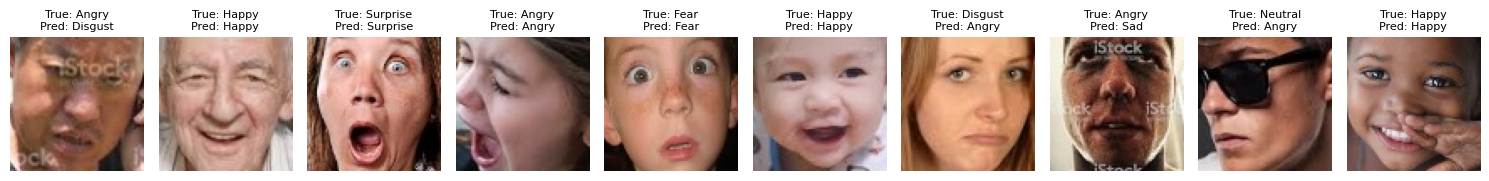

In [16]:
import matplotlib.pyplot as plt
model_name = "./vit-micro-facial-expressions"



# Load the fine-tuned ViT model and its feature extractor
feature_extractor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)
model.eval()

# Load the micro-expression dataset

dataset = processed_test

# Define the mapping from label ID to human-readable text


# 2. Get predictions and visualize results for a subset of the dataset
num_images_to_display = 10
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

print("Displaying images with predictions:")
for i in range(num_images_to_display):
    # Select a random image from the dataset
    sample = dataset[i]
    image = sample['image']
    true_label_id = sample['label']
    print(true_label_id)

    # Preprocess the image for the ViT model
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label_id = logits.argmax(-1).item()

    # Get the true and predicted labels as strings
    
    true_label = id_to_emotion[true_label_id]
    predicted_label = id_to_emotion[predicted_label_id ]
    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=8)
    axes[i].axis('off')

    print(f"Image {i+1}: True Label -> '{true_label}', Predicted Label -> '{predicted_label}'")

plt.tight_layout()
plt.show()